# Constructing Quantum Circuits in QuAIRKit

QuAIRKit uses the `Circuit` class to represent quantum circuits. In this tutorial, we will learn how to manipulate quantum circuits in QuAIRKit.

**Table of Contents**

- [Constructing quantum circuits](#Constructing-Quantum-Circuits)
  - [Add operations](#Add-operaions)
  - [Add circuit templates](#Add-circuit-templates)
  - [Operator management](#Operator-management)
  - [Execution](#Execution)
- [Other properties](#Other-properties)
- [Training noisy ground state preparation](Training-noisy-ground-state-preparation)

In [100]:
import time
from quairkit import Circuit
from quairkit.database import *
from quairkit.operator import RZ
from quairkit.qinfo import *

## Constructing quantum circuits

In QuAIRKit, circuits can be generated with or without specifying the total number of qubits.

In [101]:
num_qubits = 3

cir = Circuit() # Create a dynamic circuit

### Add gates

Constant gates can be directly called from the attributes of the `Circuit` class. The semantic rule for specifying the locations added operations is as follows:

- No inputs: The operations are added across all qubits.
- `int`: The single-qubit operation is added to the specified qubit.
- `List[int]`: The single-qubit operation is added across the specified qubits, or the multi-qubit operation is added across the specified qubits.
- `List[List[int]]`: The multi-qubit operation is added across different groups of specified qubits.

```python

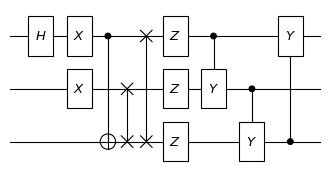

In [102]:
cir.h(0) # Add Hadamard gate to qubit 0
cir.x([0, 1]) # Add X gate to qubit 0 and 1
cir.cx([0, 2]) # Add CNOT gate to qubit 0 and 2
cir.swap([[1, 2], [0, 2]]) # Add SWAP gate to qubit 1 and 2, and qubit 0 and 2
cir.z() # Add Z gate to all qubits
cir.cy() # Add CY gate in cycle
cir.plot()

When the number of qubits is not specified, the total number of qubits will be changed as operations are added to the circuit. However, in this case, one cannot add the first operation without specifying the location.

In [103]:
print(cir.num_qubits)

3


For parametrized gates, `Circuit` can add the gate with randomly generated parameters, or you can specify them as keyword arguments.

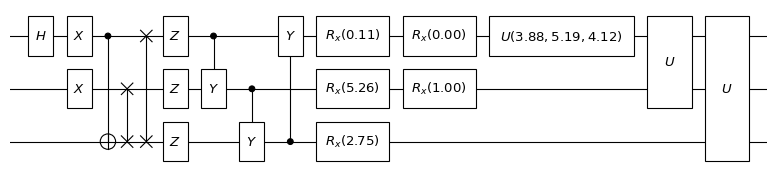

In [104]:
cir.rx() # Add Rx gate to all qubits with random parameters
cir.rx([0, 1], param=np.arange(2)) # Add RX gate to the first two qubits with specified parameters

cir.u3([0]) # Add universal single qubit gate
cir.universal_two_qubits([0, 1]) # Add universal two qubits gate
cir.universal_three_qubits([0, 1, 2]) # Add universal three qubits gate
cir.plot()

You can also add custom gates by specifying the matrix representation of the gate.

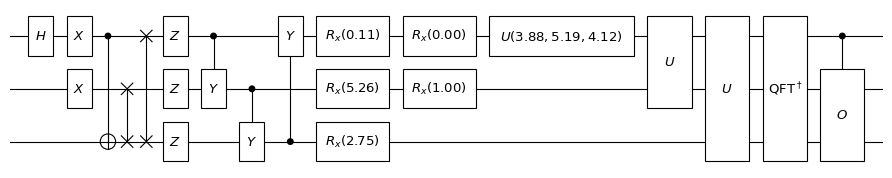

In [105]:
cir.oracle(dagger(qft_matrix(3)), qubits_idx=[0, 1, 2], latex_name=r'$\text{QFT}^\dagger$')
cir.control_oracle(random_unitary(2), qubits_idx=[0, 1, 2], gate_name='O')
cir.plot()

Similar construction semantic applies to noisy operations such as depolarizing channel, where the related plot logic is not supported yet.

In [106]:
cir.depolarizing(0.1) # Add depolarizing noise with probability 0.1
cir.bit_phase_flip(0.2) # Add bit-phase flip noise with probability 0.2

sigma = random_state(3)
cir.choi_channel(replacement_choi(sigma), qubits_idx=[0, 1, 2]) # Add replacement channel
cir.kraus_channel(reset_kraus([0.1, 0.2]), qubits_idx=[1, 2]) # Add reset channel

More available operations can be found in the [API document](www.quairkit.com).

### Add circuit templates

If you find it hard to construct the training circuit from scratch, you can use the predefined circuit templates in QuAIRKit. Note that the templates are only available for the circuits with a known number of qubits.

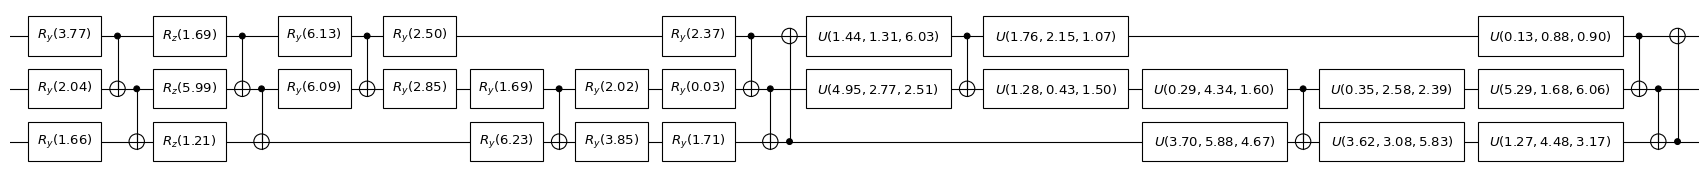

In [107]:
cir = Circuit(num_qubits)

cir.linear_entangled_layer(depth=1)

cir.real_block_layer(depth=1)
cir.real_entangled_layer(depth=1)

cir.complex_block_layer(depth=1)
cir.complex_entangled_layer(depth=1)

cir.plot()

### Operator management

`Circuit` is essentially a list of `Operator` objects. Thus, you can access the operations by indexing the `Circuit` object.

In [108]:
print('The matrix of the gate at the 5th position is\n', cir[4].matrix)

The matrix of the gate at the 5th position is
 tensor([[[-0.9971+0.j, -0.0765+0.j],
         [ 0.0765+0.j, -0.9971+0.j]],

        [[-0.9955+0.j, -0.0943+0.j],
         [ 0.0943+0.j, -0.9955+0.j]]], grad_fn=<SqueezeBackward1>)


You can also add or remove the operations for advanced setup.

The quantum circuit after adding gates is: 


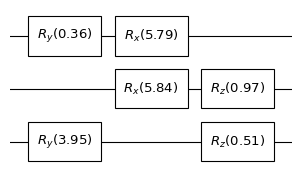

The quantum circuit after removing gates is:


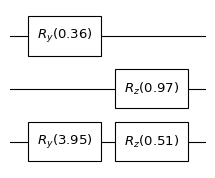

In [109]:
cir = Circuit(3)

# Set parameters and customize quantum gates. Here we select Ry, Rx, Rz gates
param = np.random.rand(2)

 # By default, randomly generates a set of parameters
rz_gate = RZ(param=param, qubits_idx=[1, 2])

# Add quantum gates
cir.ry([0, 2])
cir.rx([0, 1])
cir.insert(index=2, module=rz_gate)  # index where to insert

print('The quantum circuit after adding gates is: ')
cir.plot()

cir.pop(1)  # Remove Rx gate
print('The quantum circuit after removing gates is:')
cir.plot()

### Execution

The `Circuit` object can be executed by calling the object itself.

In [110]:
output_state = cir() # Run the circuit with initial state |0>
print('The output state for inputting zero state is:', output_state)

output_state = cir(sigma) # Run the circuit with initial state sigma
print('The output state for inputting sigma is:', output_state)

The output state for inputting zero state is: 
---------------------------------------------------
 Backend: state_vector
 System dimension: [2, 2, 2]
 System sequence: [2, 1, 0]
[-0.29+0.26j -0.05+0.05j  0.  +0.j    0.  +0.j    0.88-0.21j  0.16-0.04j
  0.  +0.j    0.  +0.j  ]
---------------------------------------------------

The output state for inputting sigma is: 
---------------------------------------------------
 Backend: density_matrix
 System dimension: [2, 2, 2]
 System sequence: [2, 1, 0]
[[ 0.09-0.j    0.06+0.03j -0.02-0.04j -0.01-0.03j  0.02+0.04j  0.07+0.11j
  -0.01+0.05j  0.12+0.05j]
 [ 0.06-0.03j  0.06+0.j   -0.04+0.01j -0.02-0.04j  0.05+0.03j  0.07+0.04j
   0.02+0.04j  0.1 -0.j  ]
 [-0.02+0.04j -0.04-0.01j  0.16+0.j   -0.06+0.06j -0.03-0.12j -0.05+0.07j
  -0.04-0.09j -0.04-0.j  ]
 [-0.01+0.03j -0.02+0.04j -0.06-0.06j  0.08-0.j   -0.06+0.08j -0.02-0.03j
  -0.04+0.04j -0.05+0.06j]
 [ 0.02-0.04j  0.05-0.03j -0.03+0.12j -0.06-0.08j  0.13-0.j   -0.01+0.01j
   0.08-0.j    

## Other properties

Circuit have other properties for further information and manipulation.

In [111]:
print('The circuit depth is', cir.depth)
print('The unitary matrix of this circuit is\n', cir.unitary_matrix())

The circuit depth is 2
The unitary matrix of this circuit is
 tensor([[-0.2855+0.2624j, -0.6660+0.6122j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0513-0.0472j,  0.1197-0.1100j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.8807-0.2067j, -0.3775+0.0886j,  0.0000+0.0000j,  0.0000+0.0000j,
         -0.1583+0.0372j,  0.0678-0.0159j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j, -0.3775-0.0886j, -0.8807-0.2067j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0678+0.0159j,  0.1583+0.0372j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.6660+0.6122j, -0.2855-0.2624j,
          0.0000+0.0000j,  0.0000+0.0000j, -0.1197-0.1100j,  0.0513+0.0472j],
        [-0.0513+0.0472j, -0.1197+0.1100j,  0.0000+0.0000j,  0.0000+0.0000j,
         -0.2855+0.2624j, -0.6660+0.6122j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.1583-0.0372j, -0.0678+0.0159j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.8807-0.2067j, -0.3775+0.0886j,  0.0000+0.0000j,  0.0000+0.0000j],
        

In [112]:
print('The trainable parameters of entire circuit is', cir.param)
cir.update_param(torch.ones_like(cir.param)) # Update the parameters of the circuit
print('The trainable parameters of entire circuit is', cir.param)

The trainable parameters of entire circuit is tensor([0.3557, 3.9515])
The trainable parameters of entire circuit is tensor([1., 1.])


It is worth noting that `Circuit` is inherently a subclass of `torch.Module`, which means that it can be used as a part of the neural network model in PyTorch.

## Training noisy ground state preparation

In this demo, we will prepare the ground state of a randomly generated Hamiltonian. In particular, we suppose the output state contains a depolarizing channel with error parameter 0.1. The loss function is defined as the expectation value of the circuit with respect to the Hamiltonian.

In [113]:
hamiltonian = random_hamiltonian_generator(num_qubits)

# construct QNN
cir = Circuit(num_qubits)
cir.complex_entangled_layer(depth=20)
cir.depolarizing(0.1)

# define loss function
loss_fcn = lambda circuit: circuit().expec_val(hamiltonian)

# set optimizer
LR, NUM_ITR = 0.1, 200
opt = torch.optim.Adam(lr=LR, params=cir.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5) # activate scheduler

In [114]:
loss_list, time_list = [], []

for itr in range(NUM_ITR):
    start_time = time.time()
    opt.zero_grad()

    loss = loss_fcn(cir) # compute loss

    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    loss_list.append(loss)
    time_list.append(time.time() - start_time)

    if itr % 20 == 0 or itr == NUM_ITR - 1:
        print(f"iter: {itr}, loss: {loss:.8f}, avg_time: {np.mean(time_list):.4f}s")
        time_list = []

iter: 0, loss: -0.14351884, avg_time: 0.0351s
iter: 20, loss: -1.08153820, avg_time: 0.0249s
iter: 40, loss: -1.15248334, avg_time: 0.0225s
iter: 60, loss: -1.15756059, avg_time: 0.0252s
iter: 80, loss: -1.15914619, avg_time: 0.0228s
iter: 100, loss: -1.15918970, avg_time: 0.0234s
iter: 120, loss: -1.15919995, avg_time: 0.0230s
iter: 140, loss: -1.15920043, avg_time: 0.0223s
iter: 160, loss: -1.15920222, avg_time: 0.0230s
iter: 180, loss: -1.15873241, avg_time: 0.0230s
iter: 199, loss: -1.14867520, avg_time: 0.0213s
